In [10]:
import numpy as np
import pymatgen.io.lammps.data
import data_analysis.data.read
import pandas as pd
import pathlib

In [2]:
system_data = data_analysis.data.read.read_lammps_system_data(
    pathlib.Path("/home/egor/Projects/bachelor-thesis/experiments/1-FENE_beadspring/data/FENE_initial_system.data"),
)
system_data.atoms

,molecule-ID,type,x,y,z,ix,iy,iz
1,1,1,0.000000,0.000000,0.000000,0,0,0
2,1,1,0.725230,-0.225160,0.603526,0,0,0
3,1,2,0.310438,0.450052,0.044120,0,0,0
4,1,2,0.680324,0.295142,0.927345,0,0,0
5,1,2,0.402564,0.322670,1.856318,0,0,0
...,...,...,...,...,...,...,...,...
2556,20,2,0.142664,-8.078942,4.455773,0,0,0
2557,20,2,0.616889,-8.352064,3.654889,0,0,0
2558,20,2,-0.316484,-8.550768,3.481018,0,0,0
2559,20,2,-1.264813,-8.348350,3.505501,0,0,0


In [3]:
trajectory_df = pd.concat(data_analysis.data.read.read_lammps_custom_trajectory_file(
    pathlib.Path("/home/egor/Projects/bachelor-thesis/experiments/1-FENE_beadspring/data/polymer_relax.out"),
    column_types={
        "t": int,
        "id": int,
        "type": int,
        "x": float,
        "y": float,
        "z": float,
        "ix": int,
        "iy": int,
        "iz": int
    }
)).join(
    system_data.atoms["molecule-ID"],
    on="id"
)
trajectory_df

,t,id,type,x,y,z,ix,iy,iz,molecule-ID
0,0,1,1,0.000000,0.000000,0.000000,0,0,0,1
1,0,2,1,0.725230,-0.225160,0.603526,0,0,0,1
2,0,3,2,0.310438,0.450052,0.044120,0,0,0,1
3,0,4,2,0.680324,0.295142,0.927345,0,0,0,1
4,0,5,2,0.402564,0.322670,1.856320,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2555,10000000,2556,2,3.391180,25.362200,16.782900,0,0,0,20
2556,10000000,2557,2,3.493220,26.052100,17.413400,0,0,0,20
2557,10000000,2558,2,3.601600,26.574800,18.163800,0,0,0,20
2558,10000000,2559,2,4.023410,27.094600,18.850700,0,0,0,20


In [4]:
trajectory_df.groupby("molecule-ID")["t"].count()

molecule-ID
1     12928
2     12928
3     12928
4     12928
5     12928
6     12928
7     12928
8     12928
9     12928
10    12928
11    12928
12    12928
13    12928
14    12928
15    12928
16    12928
17    12928
18    12928
19    12928
20    12928
Name: t, dtype: int64

In [8]:
system_data.box.bounds

[[-100.0, 100.0], [-100.0, 100.0], [-100.0, 100.0]]

In [13]:
def unfold_coordinate(val: float, i: float, box_length: float):
    return val + i * box_length


def calculate_end_to_end(molecule_traj_step_df: pd.DataFrame):
    root_atom_data = molecule_traj_step_df.loc[molecule_traj_step_df["type"] == 1].sort_values("id").iloc[0]
    leaf_atom_data = \
        molecule_traj_step_df.loc[molecule_traj_step_df["type"] == 3].sort_values("id", ascending=False).iloc[0]

    root_coordinates_unfolded = np.zeros(3)
    leaf_coordinates_unfolded = np.zeros(3)

    for dim_i, dim_name in enumerate(('x', 'y', 'z')):
        root_coordinates_unfolded[dim_i] = unfold_coordinate(
            val=root_atom_data[dim_name],
            i=root_atom_data[f"i{dim_name}"],
            box_length=system_data.box.bounds[dim_i][1] - system_data.box.bounds[dim_i][0]
        )

        leaf_coordinates_unfolded[dim_i] = unfold_coordinate(
            val=leaf_atom_data[dim_name],
            i=leaf_atom_data[f"i{dim_name}"],
            box_length=system_data.box.bounds[dim_i][1] - system_data.box.bounds[dim_i][0]
        )

    return np.linalg.norm(leaf_coordinates_unfolded - root_coordinates_unfolded)


end_to_end_df = trajectory_df.groupby(["molecule-ID", "t"]).apply(calculate_end_to_end)

In [14]:
end_to_end_df

molecule-ID  t       
1            0           17.552370
             100000      22.909821
             200000      26.547870
             300000      20.956973
             400000      24.484807
                           ...    
20           9600000     18.815108
             9700000     24.712559
             9800000     27.352942
             9900000     22.792695
             10000000    33.894875
Length: 2020, dtype: float64

<Axes: xlabel='t'>

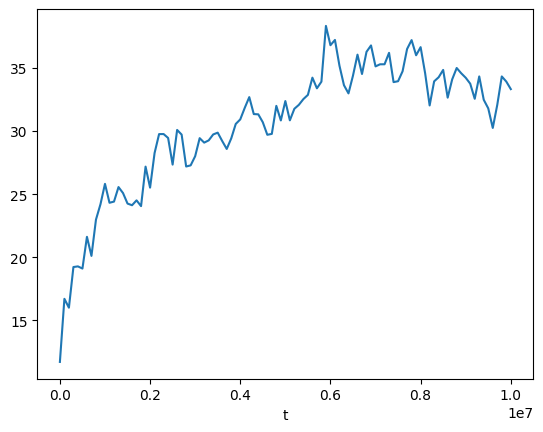

In [18]:
end_to_end_df.groupby("t").mean().plot()

<Axes: xlabel='t'>

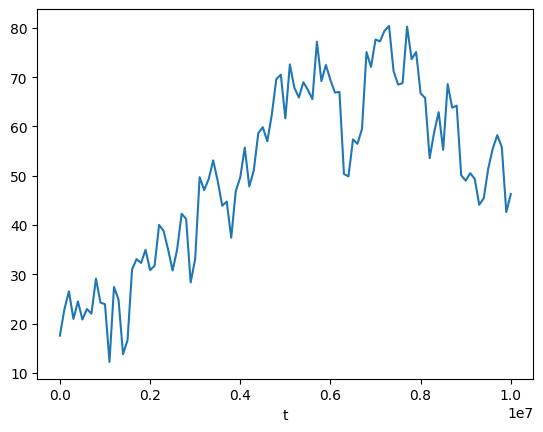

In [16]:
end_to_end_df.loc[1].plot(x="t", y="data")